<a href="https://colab.research.google.com/github/HiepPham1412/cifa_img_classification/blob/master/CIFAR_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Image classification - ConvNet (Cont)

#3.0  Environment set up

Ensure that you chose to GPU. Go to ** Runtime > Change runtime type > GPU**

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
('Gen RAM Free: 12.9 GB', ' | Proc size: 151.3 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


##  Setup R kernel

As Google colab has not supported R as yet, we need to change the default python2 kernel to R kernel. This may take up to 5 minutes.

In [0]:
import datetime
t1 = datetime.datetime.now()
!wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x ./Miniconda3-latest-Linux-x86_64.sh
!./Miniconda3-latest-Linux-x86_64.sh -b -p /conda  > /dev/null 2>&1 
!/conda/bin/conda install -c r r-rstan r-irkernel gxx_linux-64 -y -q > /dev/null 2>&1
!/conda/bin/R -e "IRkernel::installspec(name = 'python2', displayname = 'R', user = FALSE)"  > /dev/null 2>&1
!mkdir /root/.R/
!echo "CXX14FLAGS=-O3 -mtune=native -march=native -Wno-ignored-attributes -Wno-deprecated-declarations" > /root/.R/Makevars
t2 = datetime.datetime.now()
print(t2 - t1)

--2019-02-01 09:08:07--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.16.18.10, 104.16.19.10, 2606:4700::6810:130a, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.16.18.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69826864 (67M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  66.59M   170MB/s    in 0.4s    

2019-02-01 09:08:07 (170 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [69826864/69826864]

0:02:12.978563


**Check if we are using GPU**

*If you are running on the TensorFlow or CNTK backends, your code will automatically run on GPU if any available GPU is detected* - [documentation](https://keras.io/getting-started/faq/#how-can-i-run-keras-on-gpu)

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1511289483429175658
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14610941167998458316
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4641922346631308765
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4266702493010206610
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## Install necessary packages

Install necessary packages before training our model

In [0]:
# !git clone https://github.com/HiepPham1412/cifa_img_classification.git
# !/conda/bin/conda  install -c r r-dplyr 
!/conda/bin/conda install -y -c conda-forge/label/gcc7 r-keras 
!/conda/bin/conda install -y -c r r-dplyr 
#!/conda/bin/conda install -y -c r r-devtools 
!/conda/bin/conda install -y -c r r-purrr

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /conda

  added / updated specs:
    - r-keras


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2018.10.15 |       ha4d7672_0         135 KB  conda-forge/label/gcc7
    certifi-2018.8.24          |        py37_1001         139 KB  conda-forge/label/gcc7
    cryptography-2.3.1         |py37hb7f436b_1000         594 KB  conda-forge/label/gcc7
    curl-7.63.0                |    h646f8bb_1000         144 KB  conda-forge/label/gcc7
    krb5-1.16.2                |    hc83ff2d_1000         1.4 MB  conda-forge/label/gcc7
    libcurl-7.63.0             |    h01ee5af_1000         552 KB  conda-forge/l



---



Now, go to menu **Runtime -> Manage Sessions -> TERMINATE**.  

Finally, **RECONNECT**.



---



# 3.1.AlexNet
Alexnet is the winning architecture in 2012 of ImageNet competition. Although its not the state of the art model, its simpler configuration is less computational expensive than the recent ones.

In this project, due to difference in image input size, we will adjust the size of the kernel as well as the number of filters. 

In [0]:
# load necessary library
library('tensorflow')
library('keras')
library('dplyr')
# loading the data
cifar <- dataset_cifar10()

options(silent=FALSE)
set.seed(123)

n_train <-7000
n_test <-3000
# we only use 10% of total data set or 10,000 out of 60000
train_x <- cifar$train$x[1:n_train,,,]/255
train_y <- to_categorical(cifar$train$y[1:n_train], num_classes = 10)

# we prepare the TESTING dataset 
test_x <- cifar$test$x[1:n_test,,,]/ 255
test_y <- to_categorical(cifar$test$y[1:n_test], num_classes = 10) 

# verification of dimensions
dim(train_x) 
cat("Number of obs. in the training dataset:",
    dim(train_x)[[1]],
    "\nNumber of obs. in the testing dataset:",
    dim(test_x)[[1]])



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



[1] 7000   32   32    3

Number of obs. in the training dataset: 7000 
Number of obs. in the testing dataset: 3000

Define a training function which allow different hyperparameter configurations


In [0]:

Alexnet_train <- function(train_x,
                          train_y,
                          filters = list(c(32,32,64,64,64)), # size of 5 filters
                          kernels = list(list(c(6,6),c(3,3),c(3,3),c(3,3),c(3,3))),# size of 5 kernels
                          dense_1 = 64,
                          drop_out_rate = 0.4,
                          out_put_act = 'softmax',
                          learning_rate = 0.001,
                          epochs_no=150){
  k <-3
  acc_validation <-c()
  acc_train <-c()
  
  for (j in 1:k){
    print(paste0('cross_val_loop: ',j))
    if (k==1){
      train_x.cv <- train_x
      train_y.cv <- train_y
      test_x.cv <- test_x
      test_y.cv <- test_y    
    }else{
      index <- sample(1:nrow(train_x), round((k-1)/k*nrow(train_x))) 
      train_x.cv <- train_x[index,,,]
      train_y.cv <- train_y[index,]
      test_x.cv <- train_x[-index,,,]
      test_y.cv <- train_y[-index,]
    }
    # define model
    AlexNet = keras_model_sequential()
    AlexNet%>%  
        # 1st Convolutional Layer -------------------------------
        layer_conv_2d(filter = filters[[1]][1],
                    kernel_size = c(kernels[[1]][[1]]),
                    padding = "same",         
                    input_shape =c(32,32,3))%>%
        layer_activation("relu")%>%
        layer_batch_normalization()%>%
        layer_max_pooling_2d(pool_size=c(2,2), strides = c(2,2),padding = "same")%>%
        # 2nd Convolutional Layer -------------------------------
        layer_conv_2d(filter = filters[[1]][2],
                    kernel_size = c(kernels[[1]][[2]]),
                    strides=c(1,1),
                    padding = "same") %>%  
        layer_activation("relu")%>%
        layer_batch_normalization()%>%
        layer_max_pooling_2d(pool_size=c(2,2), strides = c(2,2),padding = "same")%>%
        # 3rd Convolutional Layer -------------------------------
        layer_conv_2d(filter = filters[[1]][3],
                    kernel_size = c(kernels[[1]][[3]]),
                    strides=c(1,1),
                    padding = "same")%>%
        layer_activation("relu")%>%
        layer_batch_normalization()%>%
        # 4th Convolutional Layer -------------------------------
        layer_conv_2d(filter = filters[[1]][4],
                    kernel_size = c(kernels[[1]][[4]]),
                    strides=c(1,1),
                    padding = "same") %>%  
        layer_activation("relu")%>%
        # 5th Convolutional Layer -------------------------------
        layer_conv_2d(filter = filters[[1]][5],
                    kernel_size = c(kernels[[1]][[5]]),
                    strides=c(1,1),
                    padding = "same") %>%  
        layer_activation("relu")%>%
        layer_batch_normalization()%>%
        layer_max_pooling_2d(pool_size=c(2,2), strides = c(2,2),padding = "same")%>%
        # Passing it to a Fully Connected layer
        layer_flatten() %>%  
        layer_dense(dense_1,activation='relu')%>%
        layer_dropout(drop_out_rate)%>%
        layer_batch_normalization()%>%
        # output layer
        layer_dense(10,activation=out_put_act)
    #--optimizer
    opt <- optimizer_adam(lr = learning_rate, decay = 1e-6)
    AlexNet %>%
      compile(loss = "categorical_crossentropy",
              optimizer = opt,
              metrics = "accuracy")

    # TRAINING THE MODEL 
    # generating images
    gen_images <- image_data_generator(rotation_range = 15,
                                       width_shift_range = 0.15,
                                       height_shift_range = 0.15,
                                       horizontal_flip = TRUE)

    # Fit image data generator internal statistics to some sample data
    gen_images %>% fit_image_data_generator(train_x)

    # Generates batches of augmented/normalized data from image data and 
    # labels to visually see the generated images by the model
    history_Alex <- AlexNet %>% fit_generator(
      flow_images_from_data(train_x.cv, 
                            train_y.cv, 
                            gen_images,
                            batch_size = 32
      ),
      steps_per_epoch = as.integer(n_train/32),
      epochs = epochs_no,
      validation_data = list(test_x.cv, test_y.cv),
      verbose=1)
    # Evaluation of the model performance on the TESTING data
    acc_train <- c(acc_train,history_Alex$metrics$acc[epochs_no])
    acc_validation <-c(acc_validation,history_Alex$metrics$val_acc[epochs_no])
    }
  #list(mean(acc_train),mean(acc_validation),AlexNet)
  return (list(mean(acc_validation),mean(acc_train),AlexNet,history_Alex))
}



Create a parameter grid to explore different combinations of the hyperparameters. Due to the computation cost contrains, we cant explore a reasonable combination. Only a few hyper-parameters are explored. In addition, 3-fold cross-validation is used instead of 5 in other machine learning techniques (SVM).

In [0]:
tuneGrid <- expand.grid(learning_rate = c(0.001),
                        filters = c(list(c(32,32,64,128,128)),list(c(32,64,128,128,256))), # size of 5 filters
                        kernels = c(list(list(c(6,6),c(3,3),c(3,3),c(3,3),c(3,3)))),# size of 5 kernels
                        dense_1 = c(64,128,256,512),
                        drop_out_rate = c(0.4),
                        out_put_act = c('softmax')
                          )
tuneGrid
print(paste0('total number of possible configuration: ', nrow(tuneGrid)))

learning_rate,filters,kernels,dense_1,drop_out_rate,out_put_act
0.001,"32, 32, 64, 128, 128","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",64,0.4,softmax
0.001,"32, 64, 128, 128, 256","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",64,0.4,softmax
0.001,"32, 32, 64, 128, 128","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",128,0.4,softmax
0.001,"32, 64, 128, 128, 256","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",128,0.4,softmax
0.001,"32, 32, 64, 128, 128","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",256,0.4,softmax
0.001,"32, 64, 128, 128, 256","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",256,0.4,softmax
0.001,"32, 32, 64, 128, 128","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",512,0.4,softmax
0.001,"32, 64, 128, 128, 256","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",512,0.4,softmax


[1] "total number of possible configuration: 8"


In [0]:
acc_train_2<- c()
acc_val_2<- c()
# loop through all the configurations
print('before the loop')
for (i in 7:nrow(tuneGrid)){#nrow(tuneGrid)
  print(paste0('progress: ',i))
  paras <-tuneGrid[i,]
  pef <- Alexnet_train(train_x,
                          train_y,
                          filters =paras$filters, # size of 5 filters
                          kernels =paras$kernels ,# size of 5 kernels
                          dense_1 =paras$dense_1 ,
                          drop_out_rate =paras$drop_out_rate,
                          out_put_act = paras$out_put_act,
                          learning_rate = paras$learning_rate,
                          epochs_no=100)
  acc_val_2 <-c(acc_val_2,pef[[1]])
  acc_train_2 <-c(acc_train_2,pef[[2]])
}

tuneGrid$acc_train <-acc_train
tuneGrid$acc_val <-acc_val
tuneGrid

[1] "before the loop"
[1] "progress: 7"
[1] "cross_val_loop: 1"
[1] "cross_val_loop: 2"
[1] "cross_val_loop: 3"
[1] "progress: 8"
[1] "cross_val_loop: 1"
[1] "cross_val_loop: 2"
[1] "cross_val_loop: 3"


In [0]:
tuneGrid

learning_rate,filters,kernels,dense_1,drop_out_rate,out_put_act,acc_val,acc_train
0.001,"32, 32, 64, 128, 128","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",64,0.4,softmax,0.6885269,0.9030051
0.001,"32, 64, 128, 128, 256","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",64,0.4,softmax,0.6798114,0.9385587
0.001,"32, 32, 64, 128, 128","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",128,0.4,softmax,0.6863838,0.9163078
0.001,"32, 64, 128, 128, 256","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",128,0.4,softmax,0.6933848,0.9455450
0.001,"32, 32, 64, 128, 128","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",256,0.4,softmax,0.7032433,0.9158771
0.001,"32, 64, 128, 128, 256","6, 6, 3, 3, 3, 3, 3, 3, 3, 3",256,0.4,softmax,0.6919560,0.9522921


As we can see that the accuracy rate on the validation set is around 70%. 

Lets consider this is the best model's configuration and see how it perform on the test set.

## Evaluate the performance of the best model on test data set

In [0]:
# define model
AlexNet_best = keras_model_sequential()
AlexNet_best%>%  
    # 1st Convolutional Layer -------------------------------
    layer_conv_2d(filter = 96,
                kernel_size = c(6,6),
                padding = "same",         
                input_shape =c(32,32,3))%>%
    layer_activation("relu")%>%
    layer_max_pooling_2d(pool_size=c(2,2), strides = c(2,2),padding = "same")%>%
    # 2nd Convolutional Layer -------------------------------
    layer_conv_2d(filter = 256,
                kernel_size = c(3,3),
                strides=c(1,1),
                padding = "same") %>%  
    layer_activation("relu")%>%
    layer_batch_normalization()%>%
    layer_max_pooling_2d(pool_size=c(2,2), strides = c(2,2),padding = "same")%>%
    # 3rd Convolutional Layer -------------------------------
    layer_conv_2d(filter = 384,
                kernel_size = c(3,3),
                strides=c(1,1),
                padding = "same")%>%
    layer_activation("relu")%>%
    layer_batch_normalization()%>%
    # 4th Convolutional Layer -------------------------------
    layer_conv_2d(filter =384,
                kernel_size = c(3,3),
                strides=c(1,1),
                padding = "same") %>%  
    layer_activation("relu")%>%
    # 5th Convolutional Layer -------------------------------
    layer_conv_2d(filter = 256,
                kernel_size = c(3,3),
                strides=c(1,1),
                padding = "same") %>%  
    layer_activation("relu")%>%
    layer_batch_normalization()%>%
    layer_max_pooling_2d(pool_size=c(2,2), strides = c(2,2),padding = "same")%>%
    # Passing it to a Fully Connected layer
    layer_flatten() %>%  
    layer_dense(128,activation='relu')%>%
    layer_dropout(0.4)%>%
    layer_dense(128,activation='relu')%>%
    layer_dropout(0.4)%>%
    layer_dense(32,activation='relu')%>%
    layer_dropout(0.4)%>%
    # output layer
    layer_dense(10,activation='softmax')
#--optimizer
opt <- optimizer_adam(lr = 0.001, decay = 1e-6)
AlexNet_best %>%
  compile(loss = "categorical_crossentropy",
          optimizer = opt,
          metrics = "accuracy")

# TRAINING THE MODEL 
# generating images
gen_images <- image_data_generator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   horizontal_flip = TRUE)

# Fit image data generator internal statistics to some sample data
gen_images %>% fit_image_data_generator(train_x)

# Generates batches of augmented/normalized data from image data and 
# labels to visually see the generated images by the model
history_Alex_best <- AlexNet_best %>% fit_generator(
  flow_images_from_data(train_x, 
                        train_y, 
                        gen_images,
                        batch_size = 32
  ),
  steps_per_epoch = as.integer(n_train/32),
  epochs = 100,
  validation_data = list(test_x, test_y),
  verbose=1)

plot(history_Alex_best)

In [0]:
print(paste0('Accuracy rate of the training set: ',history_Alex_best$metrics$acc[100]))
print(paste0('Accuracy rate of the test set: ',history_Alex_best$metrics$val_acc[100]))

[1] "Accuracy rate of the training set: 0.896383467210557"
[1] "Accuracy rate of the test set: 0.722666666507721"


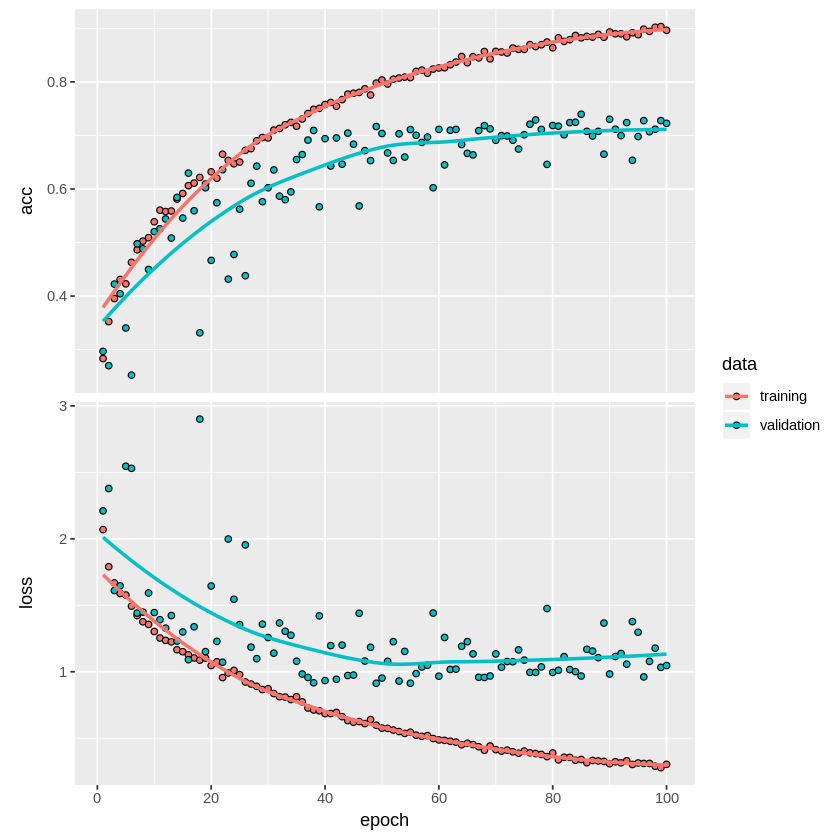

In [0]:
plot(history_Alex_best)

The best model's performance on the test set (72%) is consitent with its performance on the validaiton set.

#3.2.Transfer-learning

Transfer-learning is a way to leverage the power of pre-trained models. In paritcular,  if there is a well-tuned model trained on a large and diversifided image data set which shares many similarity to the images in our train set, we expect that the convolutional layers of these models will learn common patterns from these images and can extract meaningful pattern from our images.

Concretely, we use the below pretrained architechtures:


*   VGG16
* Restnet

Both of the above models are trained using ImageNet data which contains various images which include all the images classes on CIFAR10. Hence, we can expect that some features learned from ImageNet is relevant for CIFAR10.








### 3.2.1  VGG16

VGG16 was developed by Karen Simonyan & Andrew Zisserman (2014), which won the ImageNet competition in 2014. VGG16 explore the effect of the network depth with small filter size (3x3). 

Load the fixed weights from VGG16 and do not include the last dense layers which connected to the output variables on the ImageNet.

In [0]:
conv_base_vgg16 <- application_vgg16(
  weights = "imagenet",
  include_top = FALSE,
  input_shape = c(32,32,3))
freeze_weights(conv_base_vgg16)
cat("This is the number of trainable weights before freezing",
"the conv base:", length(conv_base_vgg16$trainable_weights), "\n")
conv_base_vgg16

This is the number of trainable weights before freezing the conv base: 0 


Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                (None, 32, 32, 3)               0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 32, 32, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 32, 32, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 16, 16, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 16, 16, 128)             73856       
________________________________________________________________________________
block2_conv2 (Conv2D) 

Define a train function which allows different parameter configuration, so it would be easier to do grid-search latter on.

In [0]:
vgg16_train <- function(train_x=train_x,
                        train_y=train_y,
                        dense_1 = 128,
                        dense_2 = 64,
                        drop_out_rate = 0.4,
                        out_put_act = 'softmax',
                        learning_rate = 0.001,
                        epochs_no=100){
  k <-3
  acc_validation <-c()
  acc_train <-c()
  # load parameters from pre-trained models
  conv_base_vgg16 <- application_vgg16(
    weights = "imagenet",
    include_top = FALSE,
    input_shape = c(32,32,3))
  #unfreeze_weights(conv_base_vgg16, from='block4_pool')
  freeze_weights(conv_base_vgg16)
  #k-fold cross-validation
  for (j in 1:k){
    print(j)
    index <- sample(1:nrow(train_x), round((k-1)/k*nrow(train_x)))
    train_x.cv <- train_x[index,,,]
    train_y.cv <- train_y[index,]
    test_x.cv <- train_x[-index,,,]
    test_y.cv <- train_y[-index,]
    # define model
    
    vgg16 <- keras_model_sequential() %>% 
      conv_base_vgg16 %>%
      layer_batch_normalization()%>%
      layer_flatten() %>% 
      layer_dropout(drop_out_rate)%>%
      layer_dense(units=dense_1, activation='relu')%>%
      layer_dropout(drop_out_rate)%>%
      layer_dense(units=dense_2, activation='relu')%>%
      layer_dropout(drop_out_rate)%>%
      layer_dense(units = 10, activation = "sigmoid")
    
    #--optimizer
    opt <- optimizer_adam(lr = learning_rate, decay = 1e-6)
    vgg16 %>%
      compile(loss = "categorical_crossentropy",
              optimizer = opt,
              metrics = "accuracy")

    # TRAINING THE MODEL 
    # generating images
    gen_images <- image_data_generator(rotation_range = 15,
                                       width_shift_range = 0.15,
                                       height_shift_range = 0.15,
                                       horizontal_flip = TRUE)

    # Fit image data generator internal statistics to some sample data
    gen_images %>% fit_image_data_generator(train_x)

    # Generates batches of augmented/normalized data from image data and 
    # labels to visually see the generated images by the model
    history_vgg16 <- vgg16 %>% fit_generator(
      flow_images_from_data(train_x.cv, 
                            train_y.cv, 
                            gen_images,
                            batch_size = 32
      ),
      steps_per_epoch = as.integer(n_train/32),
      epochs = epochs_no,
      validation_data = list(test_x.cv, test_y.cv),
      verbose=1)
    # Evaluation of the model performance on the TESTING data
    print('get result')
    acc_train <- c(acc_train,history_vgg16$metrics$acc[epochs_no])
    acc_validation <-c(acc_validation,history_vgg16$metrics$val_acc[epochs_no])

    }
  #list(mean(acc_train),mean(acc_validation),AlexNet)
  return (list(mean(acc_validation),mean(acc_train),vgg16))
}

A data.frame of hyper-parameters

In [0]:
# tuneGrid setup
tuneGrid_vgg16 <- expand.grid(learning_rate = c(0.001),
                        dense_1 = c(256,128),
                        dense_2 = c(128,64,32),
                        drop_out_rate = c(0.4),
                        out_put_act = c('softmax')
                        )
tuneGrid_vgg16
print(paste0('total number of possible configuration: ', nrow(tuneGrid_vgg16)))

learning_rate,dense_1,dense_2,drop_out_rate,out_put_act
0.001,256,128,0.4,softmax
0.001,128,128,0.4,softmax
0.001,256,64,0.4,softmax
0.001,128,64,0.4,softmax
0.001,256,32,0.4,softmax
0.001,128,32,0.4,softmax


[1] "total number of possible configuration: 6"


In [0]:
acc_train_vagg16<- c()
acc_val_vagg16<- c()
# loop through all the configurations
for (i in 1:nrow(tuneGrid_vgg16)){
  print(paste0('progress: ',i))
  paras <-tuneGrid_vgg16[i,]
  pef <- vgg16_train(train_x=train_x,
                    train_y=train_y,
                    dense_1 =paras$dense_1,
                    dense_2 = paras$dense_2,
                    drop_out_rate =paras$drop_out_rate,
                    out_put_act = paras$out_put_act,
                    learning_rate = paras$learning_rate,
                    epochs_no=150)
  acc_val_vagg16 <-c(acc_val_vagg16,pef[[1]])
  acc_train_vagg16 <-c(acc_train_vagg16,pef[[2]])
}

tuneGrid_vgg16$acc_train <-acc_train_vagg16
tuneGrid_vgg16$acc_val <-acc_val_vagg16
tuneGrid_vgg16

[1] "progress: 1"
[1] 1
[1] "get result"
[1] 2
[1] "get result"
[1] 3
[1] "get result"
[1] "progress: 2"
[1] 1
[1] "get result"
[1] 2
[1] "get result"
[1] 3
[1] "get result"
[1] "progress: 3"
[1] 1
[1] "get result"
[1] 2
[1] "get result"
[1] 3
[1] "get result"
[1] "progress: 4"
[1] 1
[1] "get result"
[1] 2
[1] "get result"
[1] 3
[1] "get result"
[1] "progress: 5"
[1] 1
[1] "get result"
[1] 2
[1] "get result"
[1] 3
[1] "get result"
[1] "progress: 6"
[1] 1
[1] "get result"
[1] 2
[1] "get result"
[1] 3
[1] "get result"


learning_rate,dense_1,dense_2,drop_out_rate,out_put_act,acc_train,acc_val
0.001,256,128,0.4,softmax,0.5587912,0.5366481
0.001,128,128,0.4,softmax,0.5124564,0.5452207
0.001,256,64,0.4,softmax,0.5408598,0.5433633
0.001,128,64,0.4,softmax,0.5044709,0.5262180
0.001,256,32,0.4,softmax,0.5306269,0.5417917
0.001,128,32,0.4,softmax,0.4904605,0.5319331


The performance on validation set as well as train set are rather poor. We expect the poor peformance on the test set as well.

In [0]:
vgg16 <- keras_model_sequential() %>% 
  conv_base_vgg16 %>%
  layer_batch_normalization()%>%
  layer_flatten() %>% 
  layer_dropout(0.4)%>%
  layer_dense(units=128, activation='relu')%>%
  layer_dropout(0.4)%>%
  layer_dense(units=128, activation='relu')%>%
  layer_dropout(0.4)%>%
  layer_dense(units = 10, activation = "sigmoid")

cat("This is the number of trainable weights after freezing",
"the conv base:", length(conv_base_vgg16$trainable_weights), "\n")
opt <- optimizer_adam(lr = 0.001, decay = 1e-6)
vgg16 %>%
  compile(loss = "categorical_crossentropy",
          optimizer = opt,
          metrics = "accuracy")

# TRAINING THE MODEL 
# generating images
gen_images <- image_data_generator(rotation_range = 15,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = TRUE)

# Fit image data generator internal statistics to some sample data
gen_images %>% fit_image_data_generator(train_x)

# Generates batches of augmented/normalized data from image data and 
# labels to visually see the generated images by the model
history_vgg16 <- vgg16 %>% fit_generator(
  flow_images_from_data(train_x, 
                        train_y, 
                        gen_images,
                        batch_size = 32
  ),
  steps_per_epoch = as.integer(n_train/32),
  epochs = 150,
  validation_data = list(test_x, test_y),
  verbose=1)

# Evaluation of the model performance on the TESTING data
vgg16 %>% evaluate(test_x, test_y)

This is the number of trainable weights after freezing the conv base: 0 


$loss
[1] 1.32437

$acc
[1] 0.548

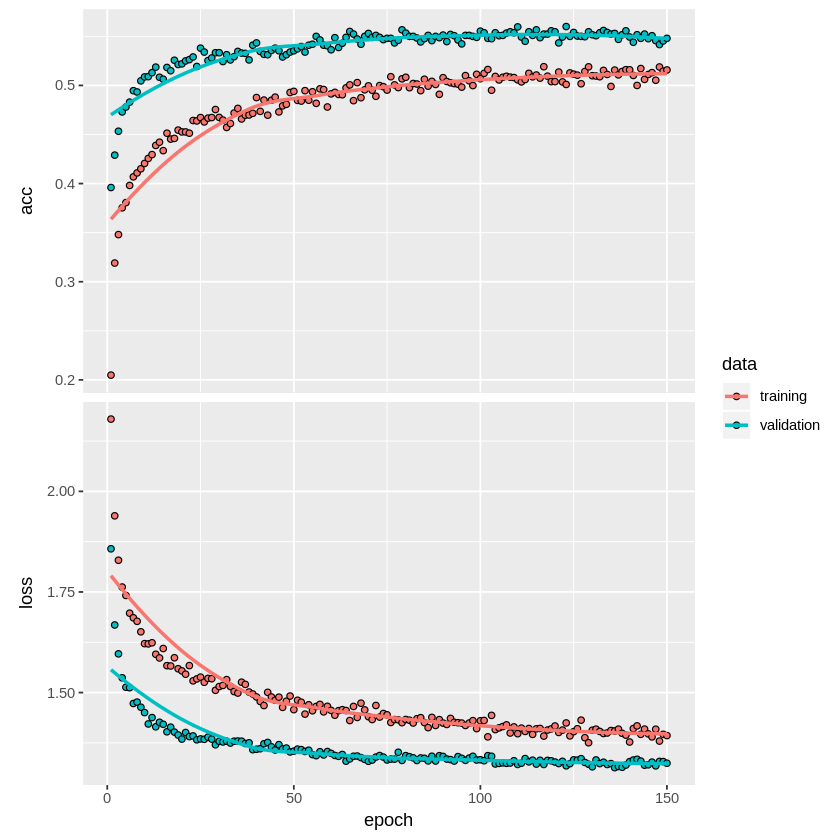

In [0]:
plot(history_vgg16)

The performance of VGG6 using all fixed pretrained parameters are rather poor. It can be understandable as the deeper layers of the network tend to learn some very specific pattern which well suit the original problem other than our problem. 

We now only fix the first few layers and retrain the very end layers with small filter size and expect it to learn the specific pattern of our problem (although it will be more computationlly expensive). In particular we retrain all the layers which contains 2x2 filters (such a small filter)

In [0]:
conv_base_vgg16_flex <- application_vgg16(
  weights = "imagenet",
  include_top = FALSE,
  input_shape = c(32,32,3))
unfreeze_weights(conv_base_vgg16_flex, from='block4_pool')
cat("This is the number of trainable weights before freezing",
"the conv base:", length(conv_base_vgg16_flex$trainable_weights), "\n")
conv_base_vgg16_flex

This is the number of trainable weights before freezing the conv base: 6 


Model
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                (None, 32, 32, 3)               0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 32, 32, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 32, 32, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 16, 16, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 16, 16, 128)             73856       
________________________________________________________________________________
block2_conv2 (Conv2D) 

In [0]:
vgg16_train_flex <- function(train_x=train_x,
                        train_y=train_y,
                        dense_1 = 128,
                        dense_2 = 64,
                        drop_out_rate = 0.4,
                        out_put_act = 'softmax',
                        learning_rate = 0.001,
                        epochs_no=100){
  k <-3
  acc_validation <-c()
  acc_train <-c()
  # load parameters from pre-trained models
  conv_base_vgg16_flex <- application_vgg16(
    weights = "imagenet",
    include_top = FALSE,
    input_shape = c(32,32,3))
  unfreeze_weights(conv_base_vgg16_flex, from='block4_pool')
  #k-fold cross-validation
  for (j in 1:k){
    print(j)
    index <- sample(1:nrow(train_x), round((k-1)/k*nrow(train_x)))
    train_x.cv <- train_x[index,,,]
    train_y.cv <- train_y[index,]
    test_x.cv <- train_x[-index,,,]
    test_y.cv <- train_y[-index,]
    # define model
    
    vgg16_flex <- keras_model_sequential() %>% 
      conv_base_vgg16_flex %>%
      layer_batch_normalization()%>%
      layer_flatten() %>% 
      layer_dropout(drop_out_rate)%>%
      layer_dense(units=dense_1, activation='relu')%>%
      layer_dropout(drop_out_rate)%>%
      layer_dense(units=dense_2, activation='relu')%>%
      layer_dropout(drop_out_rate)%>%
      layer_dense(units = 10, activation = "sigmoid")
    
    #--optimizer
    opt <- optimizer_adam(lr = learning_rate, decay = 1e-6)
    vgg16_flex %>%
      compile(loss = "categorical_crossentropy",
              optimizer = opt,
              metrics = "accuracy")

    # TRAINING THE MODEL 
    # generating images
    gen_images <- image_data_generator(rotation_range = 15,
                                       width_shift_range = 0.15,
                                       height_shift_range = 0.15,
                                       horizontal_flip = TRUE)

    # Fit image data generator internal statistics to some sample data
    gen_images %>% fit_image_data_generator(train_x)

    # Generates batches of augmented/normalized data from image data and 
    # labels to visually see the generated images by the model
    history_vgg16_flex <- vgg16_flex %>% fit_generator(
      flow_images_from_data(train_x.cv, 
                            train_y.cv, 
                            gen_images,
                            batch_size = 32
      ),
      steps_per_epoch = as.integer(n_train/32),
      epochs = epochs_no,
      validation_data = list(test_x.cv, test_y.cv),
      verbose=1)
    # Evaluation of the model performance on the TESTING data
    print('get result')
    acc_train <- c(acc_train,history_vgg16_flex$metrics$acc[epochs_no])
    acc_validation <-c(acc_validation,history_vgg16_flex$metrics$val_acc[epochs_no])

    }
  #list(mean(acc_train),mean(acc_validation),AlexNet)
  return (list(mean(acc_validation),mean(acc_train),vgg16_flex,history_vgg16_flex))
}

In [0]:
# tuneGrid setup
tuneGrid_vgg16_flex <- expand.grid(learning_rate = c(0.001),
                        dense_1 = c(256,128),
                        dense_2 = c(128),
                        drop_out_rate = c(0.4),
                        out_put_act = c('sigmoid')
                        )
tuneGrid_vgg16_flex
print(paste0('total number of possible configuration: ', nrow(tuneGrid_vgg16_flex)))

learning_rate,dense_1,dense_2,drop_out_rate,out_put_act
0.001,256,128,0.4,sigmoid
0.001,128,128,0.4,sigmoid


[1] "total number of possible configuration: 2"


In [0]:
acc_train_vagg16_flex<- c()
acc_val_vagg16_flex<- c()
model_list <-list()
hist_list <- list()
# loop through all the configurations
for (i in 1:nrow(tuneGrid_vgg16_flex)){
  print(paste0('progress: ',i))
  paras <-tuneGrid_vgg16_flex[i,]
  pef <- vgg16_train_flex(train_x=train_x,
                    train_y=train_y,
                    dense_1 =paras$dense_1,
                    dense_2 = paras$dense_2,
                    drop_out_rate =paras$drop_out_rate,
                    out_put_act = paras$out_put_act,
                    learning_rate = paras$learning_rate,
                    epochs_no=150)
  acc_val_vagg16_flex <-c(acc_val_vagg16_flex,pef[[1]])
  acc_train_vagg16_flex <-c(acc_train_vagg16_flex,pef[[2]])
  model_list <- c(model_list,pef[[3]])
  hist_list <- c(hist_list,pef[[4]])
  print(pef[[1]])
  print(pef[[2]])
}

tuneGrid_vgg16_flex$acc_train <-acc_train_vagg16_flex
tuneGrid_vgg16_flex$acc_val <-acc_val_vagg16_flex
tuneGrid_vgg16_flex

[1] "progress: 1"
[1] 1
[1] "get result"
[1] 2
[1] "get result"
[1] 3
[1] "get result"
[1] 0.7616802
[1] 0.9762349
[1] "progress: 2"
[1] 1
[1] "get result"
[1] 2
[1] "get result"
[1] 3
[1] "get result"
[1] 0.7739677
[1] 0.9767609


learning_rate,dense_1,dense_2,drop_out_rate,out_put_act,acc_train,acc_val
0.001,256,128,0.4,sigmoid,0.9762349,0.7616802
0.001,128,128,0.4,sigmoid,0.9767609,0.7739677


In [0]:
tuneGrid_vgg16_flex

learning_rate,dense_1,dense_2,drop_out_rate,out_put_act,acc_train,acc_val
0.001,256,128,0.4,sigmoid,0.9762349,0.7616802
0.001,128,128,0.4,sigmoid,0.9767609,0.7739677


The performance on the validation set is better than the AlexNet. Lets see how the model perform in the test set.

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
vgg16 (Model)                       (None, 1, 1, 512)               14714688    
________________________________________________________________________________
batch_normalization_31 (BatchNormal (None, 1, 1, 512)               2048        
________________________________________________________________________________
flatten_20 (Flatten)                (None, 512)                     0           
________________________________________________________________________________
dense_45 (Dense)                    (None, 128)                     65664       
________________________________________________________________________________
dropout_38 (Dropout)                (None, 128)                     0           
________________________________________________________________________________
batch_normalization_32 (Batc

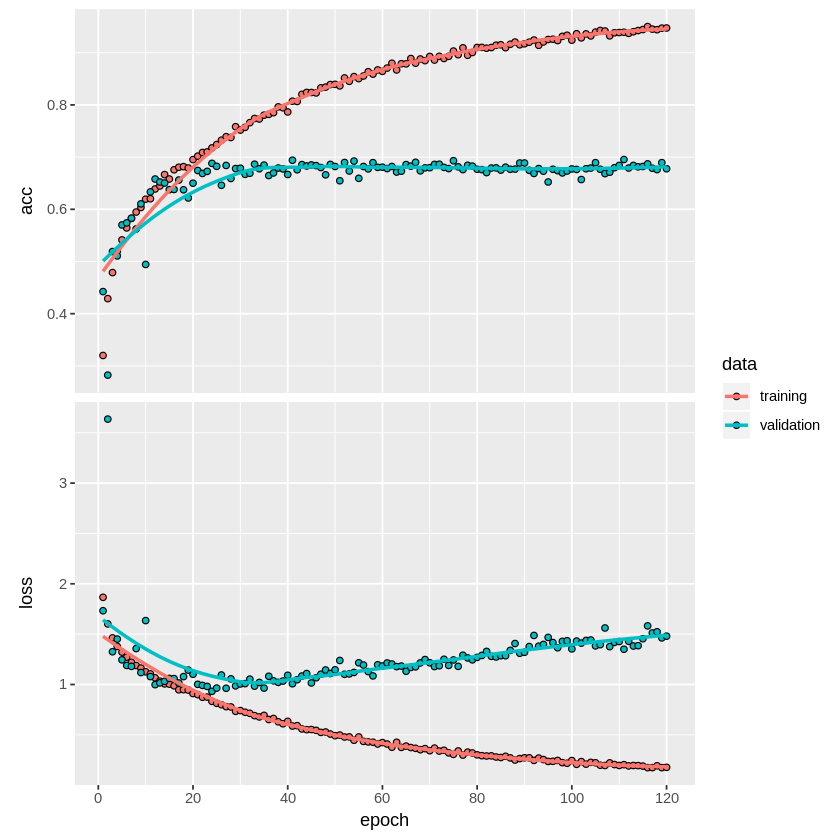

In [0]:
conv_base_vgg16_flex <- application_vgg16(
  weights = "imagenet",
  include_top = FALSE,
  input_shape = c(32,32,3))
unfreeze_weights(conv_base_vgg16_flex, from='block4_pool')
vgg16_flex <- keras_model_sequential() %>% 
  conv_base_vgg16_flex %>%
  layer_batch_normalization()%>%
  layer_flatten()%>% 
  layer_dense(units=128, activation='relu')%>%
  layer_dropout(0.4)%>%
  layer_batch_normalization()%>%
  layer_dense(units=128, activation='relu')%>%
  layer_dropout(0.4)%>%
  layer_dense(units = 10, activation = "softmax")

summary(vgg16_flex)
#--optimizer
opt <- optimizer_adam(lr = 0.001, decay = 1e-6)
#opt <- optimizer_adam(lr = 0.001, decay = 1e-6)
vgg16_flex %>%
  compile(loss = "categorical_crossentropy",
          optimizer = opt,
          metrics = "accuracy")

gen_images <- image_data_generator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   horizontal_flip = TRUE)

# Fit image data generator internal statistics to some sample data
gen_images %>% fit_image_data_generator(train_x)

# Generates batches of augmented/normalized data from image data and 
# labels to visually see the generated images by the model
history_vgg16_flex <- vgg16_flex %>% fit_generator(
  flow_images_from_data(train_x, 
                        train_y, 
                        gen_images,
                        batch_size = 32
  ),
  steps_per_epoch = as.integer(n_train/32),
  epochs = 120,
  validation_data = list(test_x, test_y),
  verbose=1)
plot(history_vgg16_flex)

In [0]:
history_vgg16_flex$metrics$val_acc[120]

[1] 0.6723333

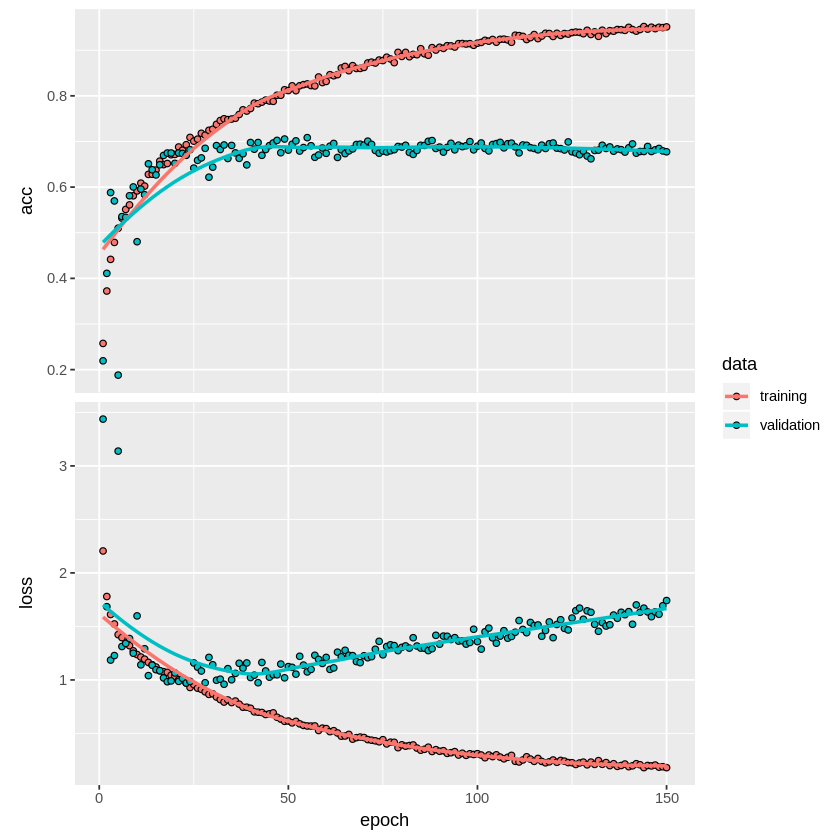

In [0]:
conv_base_vgg16_flex <- application_vgg16(
weights = "imagenet",
include_top = FALSE,
input_shape = c(32,32,3))
unfreeze_weights(conv_base_vgg16_flex, from='block4_pool')
vgg16_flex <- keras_model_sequential() %>% 
  conv_base_vgg16_flex %>%
  layer_batch_normalization()%>%
  layer_flatten()%>% 
  layer_dense(units=128, activation='relu')%>%
  layer_dropout(0.4)%>%
  layer_batch_normalization()%>%
  layer_dense(units=32, activation='relu')%>%
  layer_dropout(0.4)%>%
  layer_dense(units = 10, activation = "softmax")

#--optimizer
opt <- optimizer_adam(lr = 0.0005, beta_1 = 0.9, beta_2 = 0.999)
vgg16_flex %>%
  compile(loss = "categorical_crossentropy",
          optimizer = opt,
          metrics = "accuracy")

# TRAINING THE MODEL 
# generating images
gen_images <- image_data_generator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   horizontal_flip = TRUE)

# Fit image data generator internal statistics to some sample data
gen_images %>% fit_image_data_generator(train_x)

# Generates batches of augmented/normalized data from image data and 
# labels to visually see the generated images by the model
history_vgg16_flex <- vgg16_flex %>% fit_generator(
  flow_images_from_data(train_x, 
                        train_y, 
                        gen_images,
                        batch_size = 32
  ),
  steps_per_epoch = as.integer(n_train/32),
  epochs = 150,
  validation_data = list(test_x, test_y),
  verbose=1)
# Evaluation of the model performance on the TESTING data
plot(history_vgg16_flex)


### 3.2.2 Restnet


Restnet (2015)  is a very deep network which performed better AlexNet and VGG16 architecture. 

In [0]:
conv_base_restnet50<-application_resnet50(
  weights = "imagenet",
  include_top = FALSE,
  input_shape = c(32,32,3))
# see the structure of the model
conv_base_restnet50

Model
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
input_1 (InputLayer)      (None, 32, 32, 3) 0                                   
________________________________________________________________________________
conv1_pad (ZeroPadding2D) (None, 38, 38, 3) 0        input_1[0][0]              
________________________________________________________________________________
conv1 (Conv2D)            (None, 16, 16, 64 9472     conv1_pad[0][0]            
________________________________________________________________________________
bn_conv1 (BatchNormalizat (None, 16, 16, 64 256      conv1[0][0]                
________________________________________________________________________________
activation_1 (Activation) (None, 16, 16, 64 0        bn_conv1[0][0]             
________________________________________________________________________________
pool1_pad (ZeroPadding

In [0]:
cat("This is the number of trainable weights before freezing",
"the conv base:", length(conv_base_restnet50$trainable_weights), "\n")
unfreeze_weights(conv_base_restnet50, from = 'res4a_branch2a')
restnet50 <- keras_model_sequential() %>% 
  conv_base_restnet50 %>%
  layer_batch_normalization()%>%
  layer_flatten() %>% 
  layer_dropout(0.4)%>%
  layer_dense(units=128, activation='relu')%>%
  layer_batch_normalization()%>%
  layer_dropout(0.4)%>%
  layer_dense(units = 10, activation = "softmax")

cat("This is the number of trainable weights after freezing",
"the conv base:", length(conv_base_restnet50$trainable_weights), "\n")
summary(restnet50)

opt <- optimizer_adam(lr = 0.001, decay = 1e-6)

restnet50 %>%
  compile(loss = "categorical_crossentropy",
          optimizer = opt,
          metrics = "accuracy")

# we can print model summary and its architecture
summary(restnet50)

# TRAINING THE MODEL 
# generating images
gen_images <- image_data_generator(rotation_range = 15,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = TRUE)

# Fit image data generator internal statistics to some sample data
gen_images %>% fit_image_data_generator(train_x)

# Generates batches of augmented/normalized data from image data and 
# labels to visually see the generated images by the model
history_restnet50 <- restnet50 %>% fit_generator(
  flow_images_from_data(train_x, 
                        train_y, 
                        gen_images,
                        batch_size = 32
  ),
  steps_per_epoch = as.integer(n_train/32),
  epochs = 100,
  validation_data = list(test_x, test_y),
  verbose=1)

# Evaluation of the model performance on the TESTING data
restnet50%>% evaluate(test_x, test_y)

This is the number of trainable weights before freezing the conv base: 0 
This is the number of trainable weights after freezing the conv base: 116 
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
resnet50 (Model)                    (None, 1, 1, 2048)              23587712    
________________________________________________________________________________
batch_normalization_5 (BatchNormali (None, 1, 1, 2048)              8192        
________________________________________________________________________________
flatten_3 (Flatten)                 (None, 2048)                    0           
________________________________________________________________________________
dropout_5 (Dropout)                 (None, 2048)                    0           
________________________________________________________________________________
dense_5 (Dense)                     (None

$loss
[1] 4.485799

$acc
[1] 0.1023333

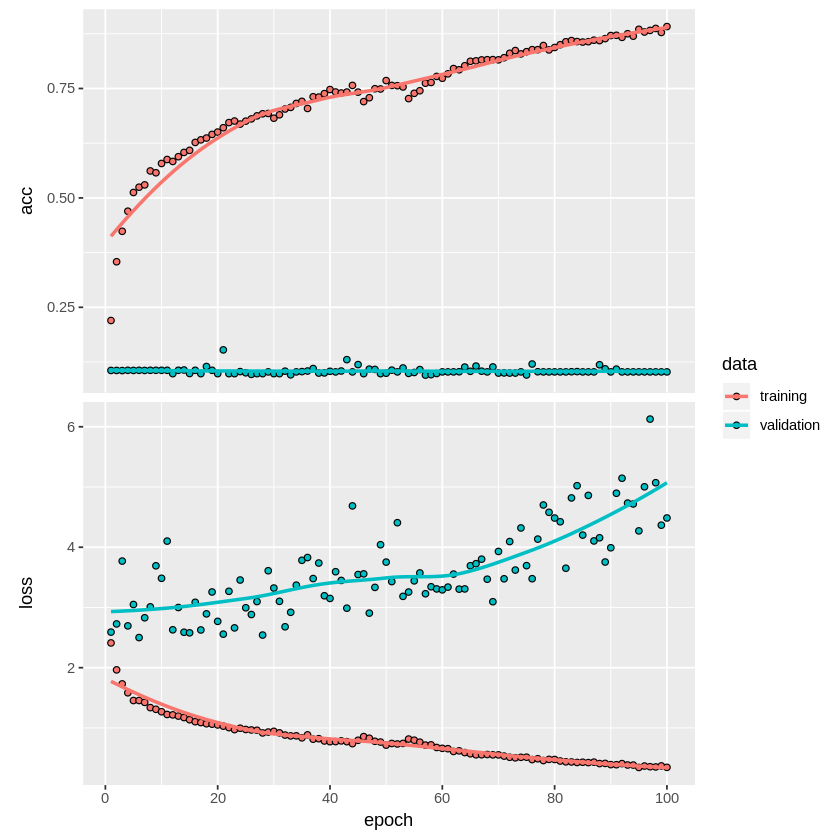

In [0]:
plot(history_restnet50)

The result is very dissapointed. This maybe due to the big filter size of the very first layers of the network. Resnet use a filter of 11x11 for its 228x228 images. This suppose to capture a small fraction of the images; however, 11x11 filter is 1/3 of our 32x32 image.

#4.Conclustion

- ConvNet perform much better than the traditional machine learning when it comes to image classification (72% accuracy vs 25% accuracy)
- Transfer learning does not outperform Alexnet. This maybe due to the big difference in image size.
-  AlexNet is the best architechture so far (72%). This is low compared with the results of other researchers (92% accuracy). Possible reasons are:

>  * We only use 10% of the data set as we constrain this problem as a small data set problem.
>  *  Hyper-parameters are not well tuned due to high computational cost. There are a lot of room to improve.


- Possible ways to further improve the model:

 > *  Rescale the image to a bigger size, so the filter of the pretrained model can learn better features
 > * Explore more model configuration.

